#Подгрузка данных с Kaggle

In [4]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
100% 1.06G/1.06G [00:51<00:00, 23.0MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.1MB/s]


In [5]:
!unzip amazon-books-reviews.zip
!rm amazon-books-reviews.zip
!rm books_data.csv

Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


# Импорт библиотек

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
from matplotlib.ticker import StrMethodFormatter

from wordcloud import WordCloud
from gensim.models import Word2Vec
import gensim.downloader as api


#EDA

In [7]:
data = pd.read_csv('Books_rating.csv')
data

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,NaN,14/19,4.0,937612800,Difficult,"This is an extremely difficult book to digest,..."
2999996,B000NSLVCU,The Idea of History,NaN,A1SMUB9ASL5L9Y,jafrank,1/1,4.0,1331683200,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...
2999997,B000NSLVCU,The Idea of History,NaN,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",0/0,4.0,1180224000,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i..."
2999998,B000NSLVCU,The Idea of History,NaN,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",1/11,5.0,1163030400,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [ ]:
print(data.isnull().sum())

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64


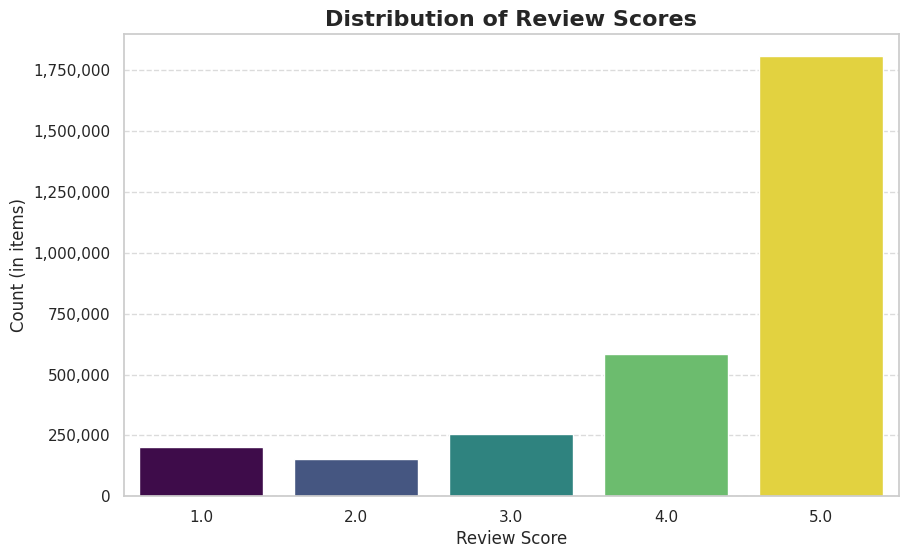

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='review/score', data=data, hue='review/score', palette='viridis', legend=False)

plt.title('Distribution of Review Scores', fontsize=16, fontweight='bold')

plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Count (in items)', fontsize=12)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
data['review/score'].value_counts()

,count
review/score,
5.0,1807343
4.0,585616
3.0,254295
1.0,201688
2.0,151058


И так, во-первых наших данных очень много. В общем случае это конечно хорошо, но поскольку мы ограничены вычислительными ресурсами колаба, будем работать с сэмплом. Вторая проблема - классы несбалансированы довольно сильно. Поэтому на этапе подготовки данных попробуем убить двух зайцев: сбалансировать классы и уменьшить объем датасета. Плюсом, сведем задачу к бинарной классификации. Ну и работать будем с двумя столбцами: review/text и review/score - наш таргет


*   Перекодируем таргет. Рейтинг 1-2 будем считать негативными отзывами, 4-5 позитивными, 3 как нейтральные рассматривать не будем ([подсмотрел здесь](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews)).
*   Применим undersampling: случайным образом выберем по 50000 негативных и позитивных отзывов.



In [8]:
data = data[['review/text', 'review/score']]

data.loc[data['review/score'].isin([1, 2]), 'review/score'] = 0
data.loc[data['review/score'].isin([4, 5]), 'review/score'] = 1

negative_reviews = data[data['review/score'] == 0]
positive_reviews = data[data['review/score'] == 1]

negative_sample = resample(negative_reviews, n_samples=50000, random_state=42)
positive_sample = resample(positive_reviews, n_samples=50000, random_state=42)

data = pd.concat([negative_sample, positive_sample])

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print(data['review/score'].value_counts())

review/score
1.0    50000
0.0    50000
Name: count, dtype: int64


In [9]:
data.columns = ['review', 'polarity']
data

,review,polarity
0,"This novel is very well written, and when you ...",1.0
1,"I like the viewpoint of the author, who seems ...",1.0
2,I was very saddened to hear how popular New Ag...,0.0
3,As with all of Max Lucado's books that I have ...,1.0
4,All you have to do is read the book to know wh...,1.0
...,...,...
99995,Jacqueline Carey has written a beautiful novel...,0.0
99996,Brice Taylor has written an incredible and cou...,1.0
99997,I am enjoying this book. I would like to comme...,1.0
99998,I think writing style and content have to be d...,0.0


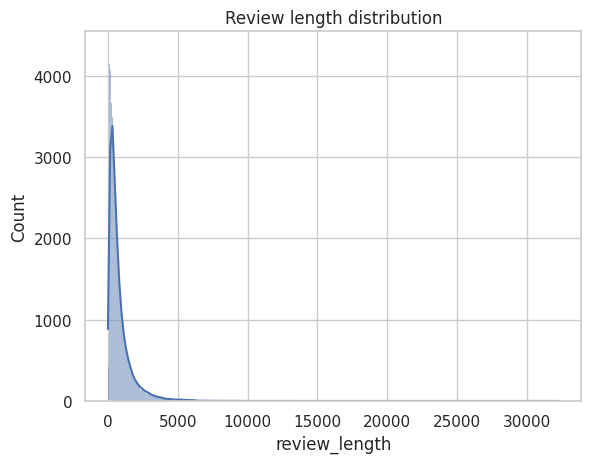

In [ ]:
# Статистика по длинам отзывов
data['review_length'] = data['review'].apply(len)
sns.histplot(data['review_length'], kde=True)
plt.title('Review length distribution')
plt.show()

In [10]:

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clear_data(text: str, lemma=True):
    # Убираем ненужные символы
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    # Токенизация
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())

    # Удаляем стоп-слова и пунктуацию
    blacklist = ['\n', '\t', '\r', ' ', '']
    tokens = [token for token in tokens if token not in blacklist and token not in english_stopwords]

    # Лемматизация или стемминг
    if lemma:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
# Применение лемматизации
data['lemma_review'] = data['review'].apply(lambda x: clear_data(x, lemma=True))

# Применение стемминга
data['stem_review'] = data['review'].apply(lambda x: clear_data(x, lemma=False))


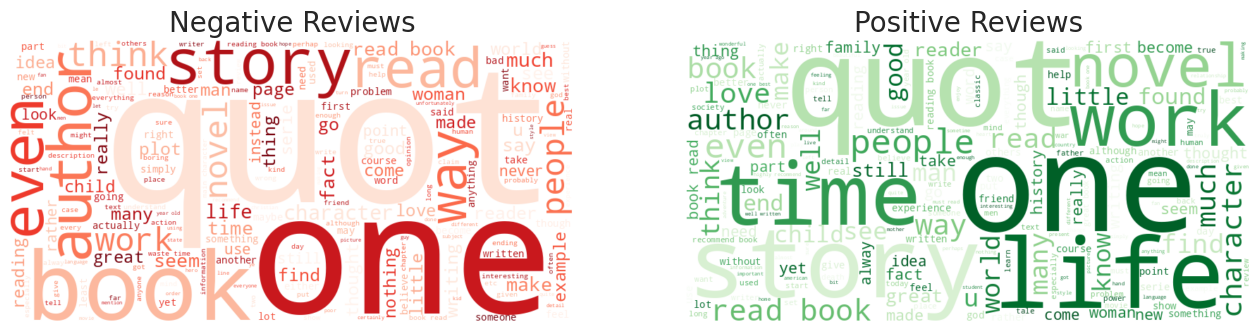

In [ ]:

negative_reviews = data[data['polarity'] == 0]['lemma_review'].tolist()
positive_reviews = data[data['polarity'] == 1]['lemma_review'].tolist()

negative_corpus = " ".join(negative_reviews)
positive_corpus = " ".join(positive_reviews)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_corpus)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_corpus)


plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews', fontsize=20)
plt.axis('off')

plt.show()


Как будто бы попробовать в будущем удалить самые популярные слова будет неплохой идеей. Будет зависеть от результатов моделирования

# Modeling

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   review         100000 non-null  object 
 1   polarity       100000 non-null  float64
 2   review_length  100000 non-null  int64  
 3   lemma_review   100000 non-null  object 
 4   stem_review    100000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.8+ MB


Попробуем самый простой one hot из коробки на непредобработанных текстах

In [ ]:

X = data['review']
y = data['polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer(binary=True)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vectorized, y_train)

y_pred = log_reg.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)

print(f"Точность на тестовой выборке: {accuracy:.4f}")


Точность на тестовой выборке: 0.8900


Достаточно высокий уровень accuracy для такого простого подхода, что даже немного удивляет. Видимо наши классы легко разделимы (что наверное логично для позитивных и негативных отзывов), а семпл взят всё-таки достаточно большой

Посмотрим что со стеммингом и лемматизацией

In [ ]:
def evaluate_model_one_hot(data, text_column, target_column='polarity'):

    X = data[text_column]
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vectorizer = CountVectorizer(binary=True)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train_vectorized, y_train)

    y_pred = log_reg.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

accuracy_lemma = evaluate_model_one_hot(data, 'lemma_review')
print(f"Точность для лемматизированных текстов: {accuracy_lemma}")
accuracy_stem = evaluate_model_one_hot(data, 'stem_review')

# Выводим результаты


print(f"Точность для стеммированных текстов: {accuracy_stem}")

Точность для лемматизированных текстов: 0.87905
Точность для стеммированных текстов: 0.8713


Наблюдается небольшое падение значений метрики. Возможно потому, что при стемминге/лемматизации мы отходим от форм слова, которые мб несут в себе тоже коннотацию. Плюс всё равно есть небольшой процент ошибок при стемминге и лемматизации. Другой причиной может быть и предобработка с удалением пунктуации (! например) и стоп-слов которые могут быть важны для понимания семантики. В идеале можно попробовать несколько видов предобработки, например, вычесть из множества стоп-слов те, которые мы считаем важными.

Попробуем немного поиграть с параметрами векторизатора. Будем учитывать количество слов, 1- и 2-граммы,дропать самые популярные слова, или те которые встречаются совсем редко. (Пробовал ещё накинуть также стандартные стоп-слова. Работает быстрее, но качество снижается)

In [ ]:

def evaluate_model(data, text_column, target_column='polarity'):

    X = data[text_column]
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vectorizer = CountVectorizer(
        binary=False,
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=5
    )
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train_vectorized, y_train)

    y_pred = log_reg.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Получаем accuracy для трех вариантов
accuracy_original = evaluate_model(data, 'review')
print(f"Точность для оригинальных текстов: {accuracy_original:.4f}")
accuracy_lemma = evaluate_model(data, 'lemma_review')
print(f"Точность для лемматизированных текстов: {accuracy_lemma:.4f}")
accuracy_stem = evaluate_model(data, 'stem_review')
print(f"Точность для стеммированных текстов: {accuracy_stem:.4f}")


Точность для оригинальных текстов: 0.9154
Точность для лемматизированных текстов: 0.9000
Точность для стеммированных текстов: 0.8972


Результат улучшился, причем лидируют по-прежнему оригинальные тексты без предобработки и использования стоп-слов.

Попробуем теперь TF-IDF

In [ ]:
%%time


def evaluate_tfidf_pipeline(texts, labels):
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm=None, smooth_idf=False,
                  stop_words='english', use_idf=False)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train_vectorized, y_train)

    y_pred = log_reg.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

accuracy_orig = evaluate_tfidf_pipeline(data['review'], data['polarity'])
print(f"Точность для оригинальных текстов: {accuracy_orig:.4f}")
accuracy_lemm = evaluate_tfidf_pipeline(data['lemma_review'], data['polarity'])
print(f"Точность для лемматизированных текстов: {accuracy_lemm:.4f}")
accuracy_stem = evaluate_tfidf_pipeline(data['stem_review'], data['polarity'])
print(f"Точность для стеммированных текстов: {accuracy_stem:.4f}")


Точность для оригинальных текстов: 0.8976
Точность для лемматизированных текстов: 0.8922
Точность для стеммированных текстов: 0.8934
CPU times: user 8min 38s, sys: 42.5 s, total: 9min 20s
Wall time: 8min 20s


In [ ]:
%%time


def evaluate_tfidf_pipeline(texts, labels):

    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm=None, smooth_idf=False, use_idf=False)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train_vectorized, y_train)

    y_pred = log_reg.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

accuracy_orig = evaluate_tfidf_pipeline(data['review'], data['polarity'])
print(f"Точность для оригинальных текстов: {accuracy_orig:.4f}")

accuracy_lemm = evaluate_tfidf_pipeline(data['lemma_review'], data['polarity'])
print(f"Точность для лемматизированных текстов: {accuracy_lemm:.4f}")

accuracy_stem = evaluate_tfidf_pipeline(data['stem_review'], data['polarity'])
print(f"Точность для стеммированных текстов: {accuracy_stem:.4f}")


Точность для оригинальных текстов: 0.9174
Точность для лемматизированных текстов: 0.9023
Точность для стеммированных текстов: 0.8993
CPU times: user 13min 4s, sys: 59.5 s, total: 14min 4s
Wall time: 12min 14s


Точность примерно на уровне ohe-hot, чуть выше. При этом без стоп слов аналогично теряем во времени и немного растем в качестве. Ну и в лидерах оригинальные тексты по классике.

Попробуем теперь word2vec эмбеддинги. Для начала пообучаем сами

In [33]:
%%time

def train_word2vec(data, text_column, vector_size=300):
    sentences = [text.split() for text in data[text_column]]
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4, seed=42)
    return word2vec_model

def get_avg_word2vec(sentence, model, num_features):
    words = sentence.split()
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model.wv.key_to_index:
            num_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def prepare_embedding_features(data, model, text_column, vector_size):
    return np.array([get_avg_word2vec(text, model, vector_size) for text in data[text_column]])

def evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Точность модели: {accuracy:.4f}")
    return accuracy

X = data['review']
y = data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

word2vec_model_base = train_word2vec(pd.DataFrame(X_train, columns=['review']), 'review', vector_size=300)

X_train_w2v = prepare_embedding_features(pd.DataFrame(X_train, columns=['review']), word2vec_model_base, 'review', vector_size=300)
X_test_w2v = prepare_embedding_features(pd.DataFrame(X_test, columns=['review']), word2vec_model_base, 'review', vector_size=300)

evaluate_logistic_regression(X_train_w2v, X_test_w2v, y_train, y_test)


Точность модели: 0.8250
CPU times: user 5min 45s, sys: 9.29 s, total: 5min 54s
Wall time: 5min 36s


0.82505

In [ ]:
%%time
X = data['lemma_review']
y = data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

word2vec_model_l = train_word2vec(pd.DataFrame(X_train, columns=['lemma_review']), 'lemma_review', vector_size=300)

X_train_l_w2v = prepare_embedding_features(pd.DataFrame(X_train, columns=['lemma_review']), word2vec_model_l, 'lemma_review', vector_size=300)
X_test_l_w2v = prepare_embedding_features(pd.DataFrame(X_test, columns=['lemma_review']), word2vec_model_l, 'lemma_review', vector_size=300)

print('Для лемматизированных:')
evaluate_logistic_regression(X_train_l_w2v, X_test_l_w2v, y_train, y_test)

Для лемматизированных:
Точность модели: 0.8462
CPU times: user 3min 25s, sys: 7.07 s, total: 3min 32s
Wall time: 2min 42s


0.8462

In [ ]:
%%time
X = data['stem_review']

y = data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

word2vec_model_s = train_word2vec(pd.DataFrame(X_train, columns=['stem_review']), 'stem_review', vector_size=300)

X_train_s_w2v = prepare_embedding_features(pd.DataFrame(X_train, columns=['stem_review']), word2vec_model_s, 'stem_review', vector_size=300)
X_test_s_w2v = prepare_embedding_features(pd.DataFrame(X_test, columns=['stem_review']), word2vec_model_s, 'stem_review', vector_size=300)

print('Для стеммированных:')
evaluate_logistic_regression(X_train_s_w2v, X_test_s_w2v, y_train, y_test)

Для стеммированных:
Точность модели: 0.8451
CPU times: user 3min 29s, sys: 8.14 s, total: 3min 37s
Wall time: 2min 38s


0.8451

Во первых видим, что точность тут ниже, чем с предыдущими статистическими экстракторами фичей. Наверное это норма, т.к. корпус не самый большой. И, что интересно, здесь предобработка повышает нам качество распознавания. Видимо очистка от мусора позволяет лучше обучать эмбеддинги, фокусируясь на важных паттернах

Попробуем также визуализировать наши тексты на плоскости в разрезе классов

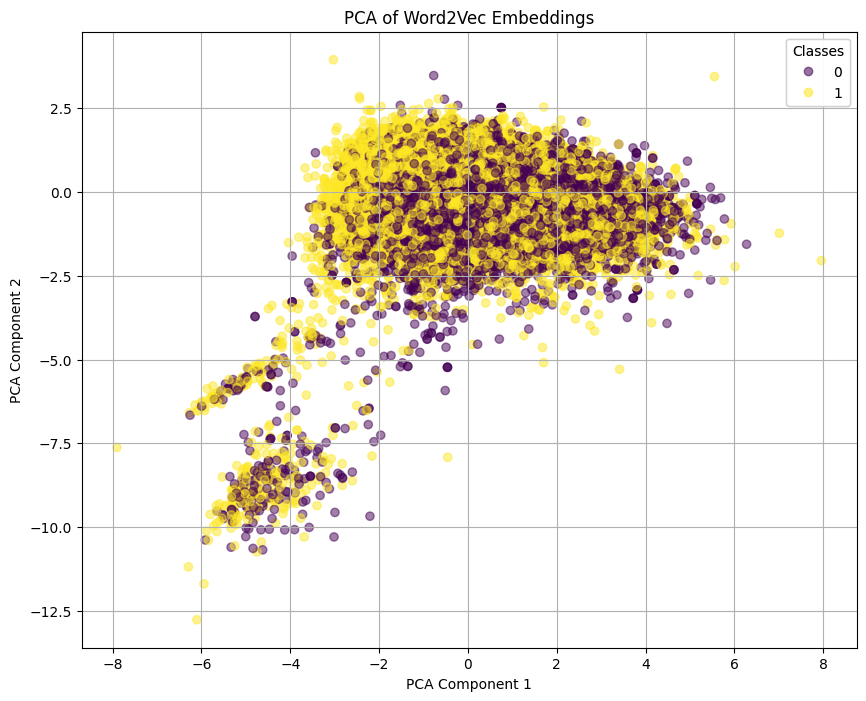

In [36]:

X_train_w2v_np = np.array(X_train_w2v.tolist())

pca = PCA(n_components=2)
X_train_w2v_pca = pca.fit_transform(X_train_w2v_np)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_w2v_pca[:, 0], X_train_w2v_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)

legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.title('PCA of Word2Vec Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

Можно увидеть 2 семантических кластера, но не в разрезе нашего таргета, интересно было бы посмотреть что это такое слева снизу. В целом, кластеры достаточно сильно смешаны, очевидным образом не разделяются. Возможно поэтому здесь logreg справляется чуть хуже

Попробуем теперь предобученные эмбеддинги

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
%%time

def get_avg_word2vec(sentence, model, num_features):
    words = sentence.split()
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model.key_to_index:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def prepare_embedding_features(data, model, text_column, vector_size):
    return np.array([get_avg_word2vec(text, model, vector_size) for text in data[text_column]])

def evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Точность модели: {accuracy:.4f}")
    return accuracy

X = data['review']
y = data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_w2v = prepare_embedding_features(pd.DataFrame(X_train, columns=['review']), word2vec_model, 'review', vector_size=300)
X_test_w2v = prepare_embedding_features(pd.DataFrame(X_test, columns=['review']), word2vec_model, 'review', vector_size=300)

evaluate_logistic_regression(X_train_w2v, X_test_w2v, y_train, y_test)






Точность модели: 0.8266
CPU times: user 54.4 s, sys: 3.22 s, total: 57.6 s
Wall time: 59.7 s


0.8266

In [ ]:
%%time
X = data['lemma_review']
y = data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_l_w2v = prepare_embedding_features(pd.DataFrame(X_train, columns=['lemma_review']), word2vec_model, 'lemma_review', vector_size=300)
X_test_l_w2v = prepare_embedding_features(pd.DataFrame(X_test, columns=['lemma_review']), word2vec_model, 'lemma_review', vector_size=300)

print('Для лемматизированных:')
evaluate_logistic_regression(X_train_l_w2v, X_test_l_w2v, y_train, y_test)

Для лемматизированных:
Точность модели: 0.8306
CPU times: user 38.1 s, sys: 2.62 s, total: 40.7 s
Wall time: 42.3 s


0.83065

In [ ]:
%%time
X = data['stem_review']
y = data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_s_w2v = prepare_embedding_features(pd.DataFrame(X_train, columns=['stem_review']), word2vec_model, 'stem_review', vector_size=300)
X_test_s_w2v = prepare_embedding_features(pd.DataFrame(X_test, columns=['stem_review']), word2vec_model, 'stem_review', vector_size=300)

print('Для стеммированных:')
evaluate_logistic_regression(X_train_s_w2v, X_test_s_w2v, y_train, y_test)

Для стеммированных:
Точность модели: 0.7876
CPU times: user 31.9 s, sys: 2.53 s, total: 34.5 s
Wall time: 35.5 s


0.7876

Ну как будто, стало только похуже, видимо есть какая-то специфика в наших текстах относительно корпуса гугл-новостей

В итоге лучшие результаты мы получили с TF-IDF в качестве экстрактора фичей (на оригинальных текстах, без стоп-слов). Попробуем с ним прогнать GridSearchCV.

Попробовали, слишком долго отрабатывает на нашем объёме данных.

In [ ]:
%%time
# Как-то слишком time-consuming

X = data['review']
y = data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm=None, smooth_idf=False, use_idf=False)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

best_model = LogisticRegression(**best_params, max_iter=1000, random_state=42)
best_model.fit(X_train_vectorized, y_train)

y_pred = best_model.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели с лучшими параметрами: {accuracy:.4f}")

KeyboardInterrupt: 

В целом, если взять более интересную модель классического ML типа XGBOOST (хотя хз насколько считается классическим уже) и хорошо подтюнить гиперпараметры, можно наверное поднять score на несколько пунктов

#NN

(пайплайн подрезал из примера)

In [1]:
!pip install torch==2.0.1 torchtext==0.15.2
# С дефолтным торчем в колабе почему-то torchtext не работал

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [3]:
!pip install -U portalocker>=2.0.0

In [2]:
import torchtext
import torch

In [22]:
data_list = data[['review', 'polarity']].to_dict(orient='records')
dataset_iter = iter(data_list)

In [14]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for obj in data_iter:
        text = obj['review']
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [15]:
tokens = tokenizer("This is a sample review text")
indexes = vocab(tokens)
print(tokens, indexes)

['this', 'is', 'a', 'sample', 'review', 'text'] [13, 10, 7, 2801, 284, 307]


In [16]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [28]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for obj in batch:
        _label = obj['polarity']
        _text = obj['review']
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(data_list, batch_size=8, shuffle=True, collate_fn=collate_batch)

In [27]:
from torch import nn

# Попробуем простую полносвязную сетку с парой fc слоев
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.fc2 = nn.Linear(embed_dim // 2, num_class)
        self.dropout = nn.Dropout(0.3)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = self.dropout(embedded)
        x = nn.functional.relu(self.fc1(x))
        return self.fc2(x)


In [29]:
num_class = 2
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [30]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count


In [31]:
import random
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


EPOCHS = 10
LR = 1e-3
BATCH_SIZE = 64

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

dataset_ = to_map_style_dataset(data_list)

split_train_, split_valid_, split_test_ = random_split(
    dataset_, [0.80, 0.05, 0.15], generator=torch.Generator().manual_seed(seed)
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    split_test_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val

    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)


| epoch   1 |   500/ 1250 batches | accuracy    0.729
| epoch   1 |  1000/ 1250 batches | accuracy    0.842
-----------------------------------------------------------
| end of epoch   1 | time: 29.60s | valid accuracy    0.877 
-----------------------------------------------------------
| epoch   2 |   500/ 1250 batches | accuracy    0.894
| epoch   2 |  1000/ 1250 batches | accuracy    0.892
-----------------------------------------------------------
| end of epoch   2 | time: 24.61s | valid accuracy    0.887 
-----------------------------------------------------------
| epoch   3 |   500/ 1250 batches | accuracy    0.919
| epoch   3 |  1000/ 1250 batches | accuracy    0.918
-----------------------------------------------------------
| end of epoch   3 | time: 24.82s | valid accuracy    0.889 
-----------------------------------------------------------
| epoch   4 |   500/ 1250 batches | accuracy    0.936
| epoch   4 |  1000/ 1250 batches | accuracy    0.933
-------------------------

In [32]:
print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.892


Нейросеть с парой FC слоев показала результат на уровне алгоритмов классического ML, которые использовались выше.
При этом accuracy на валидационной фактически не растет со 2 эпохи, возможно переобучаемся, а может наоборот быстро достигаем предела качества для нашей архитектуры. Так сразу не понятно честно говоря)
Стоило бы также попробовать с очищенными данными со стеммингом или лемматизацией, с word2vec-эмбеддингами такой подход давал лучший результат

In [37]:
!pip freeze > requirements.txt